# An exploration of factors effecting the price and quality of Airbnb listings
## Introduction

Airbnb is a popular accomodation listings site that operates around the world. In this study I will seek to get a better understanding of factors that effect the price and quality of listings. 

I will seek to do this by trying to answer the following specific questions:

1. What factors help predict price?
2. Are superhosts more expensive than non-superhosts?
3. What factors help us predict a 'superhost' ?

To help me answer these questions, I have access to a dataset of listings data that relates to Airbnb listings in Seattle, USA. While my findings therefore may include particularities to Seattle Airbnb listings - my findings may suggest answers that may also be true for listings more generally anywhere in the world.

## Data cleaning

Lets include the python libraries we will need for this project.

In [57]:
# Include libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Basic checks of data

Lets have a look at the listings data.

In [58]:
df = pd.read_csv('seattle/listings.csv')
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.000,f,nan,WASHINGTON,f,moderate,f,f,2,4.070
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.000,f,nan,WASHINGTON,f,strict,t,t,6,1.480
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.000,f,nan,WASHINGTON,f,strict,f,f,2,1.150
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,nan,f,nan,WASHINGTON,f,flexible,f,f,1,nan
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.000,f,nan,WASHINGTON,f,strict,f,f,1,0.890


In [59]:
df.shape

(3818, 92)

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

So we can see many columns have different degrees of missing values.

Let's look at the distribution of values for the numerical columns.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c20e49898>,
      dtype=object)

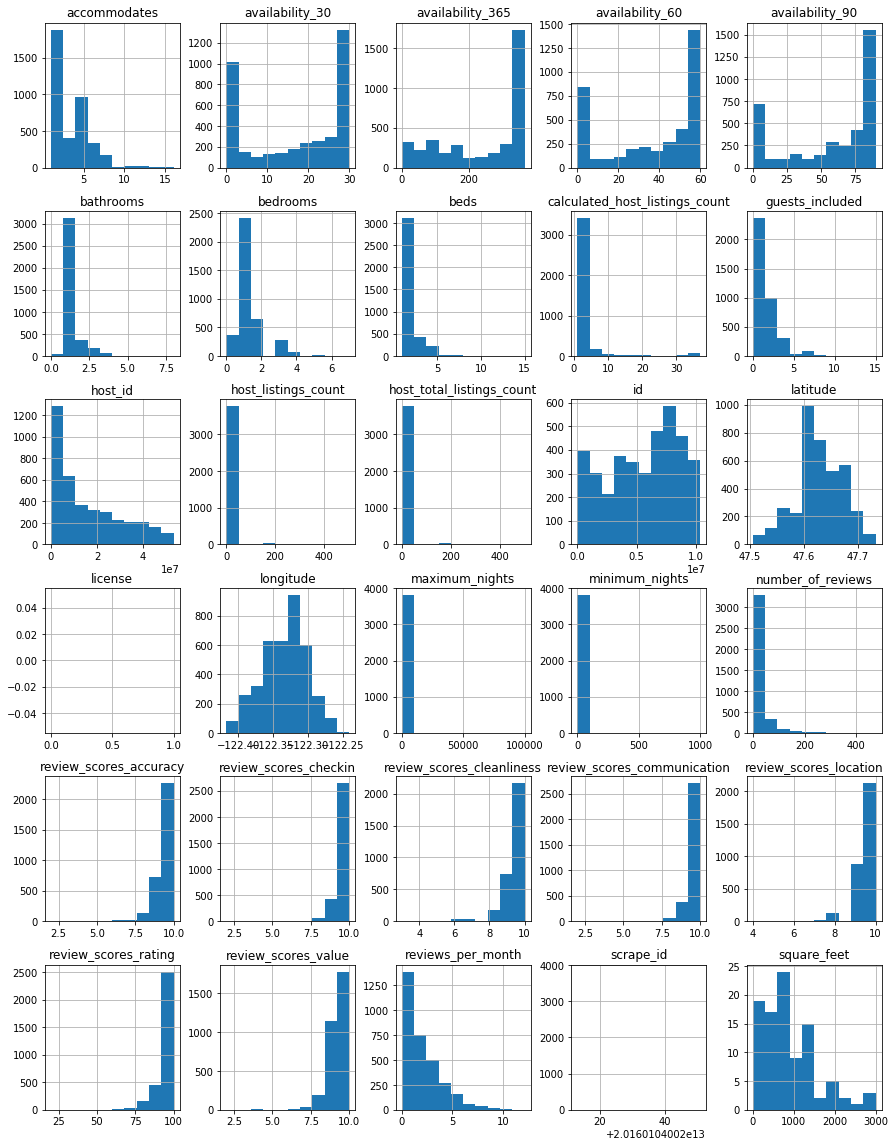

In [61]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df.hist(ax = ax)

We can see that the following fields have a highly skewed distribution: 

bathrooms, bedrooms, beds, calculated_host_listings_count, guests_included, host_listings_count, host_total_listings_count, maximum_nights, minimum_nights, number_of_reviews, review_scores_accuracy, review_scores_checkin, review_scores_cleanliness, review_scores_communication, review_scores_location, review_scores_rating, review_scores_value, reviews_per_month

We may want to consider transforming these fields for use in machine learning algorithms (e.g. a logarithmic transformation).

Lets now asess any columns with a significant number of missing values...

In [62]:
# Which columns have more than 50% values missing?
most_missing_cols = set(df.columns[df.isnull().mean() > 0.5])
most_missing_cols

{'license', 'monthly_price', 'security_deposit', 'square_feet'}

Ok so we have some columns that have more than half of values missing, and many other columns that also have null values.

Lets check for duplicated rows and columns

In [63]:
# Check for duplicate rows (by id)
df[df.duplicated(['id'], keep=False)]

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month


In [64]:
# Check for duplicate columns
df.columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

Ok looks good, no duplicated rows.

### Drop columns of no interest

So for our 3 questions of interest, I have determined the following columns are of no use and will be dropped:

'scrape_id', 'host_id', 'listing_url', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url','street', 'city', 'state', 'market','smart_location', 'country_code', 'country', 'calendar_last_scraped', 'jurisdiction_names', 'has_availability', 'requires_license'
       
The reasons are generally because these fields are:

- Text fields (e.g. name)
- Url fields (e.g. listing_url)
- Info seems to have little/no variance (e.g. 'state')
- Id's (e.g. scrape_id)

In [65]:
# Drop columns of no interest
df_clean = df.drop(['scrape_id', 'host_id', 'listing_url', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url','street', 'city', 'state', 'market', 'smart_location', 'country_code', 'country', 'calendar_last_scraped', 'jurisdiction_names', 'has_availability', 'requires_license'], axis=1)
# Check remaining columns
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 59 columns):
id                                  3818 non-null int64
host_since                          3816 non-null object
host_response_time                  3295 non-null object
host_response_rate                  3295 non-null object
host_acceptance_rate                3045 non-null object
host_is_superhost                   3816 non-null object
host_neighbourhood                  3518 non-null object
host_listings_count                 3816 non-null float64
host_total_listings_count           3816 non-null float64
host_verifications                  3818 non-null object
host_has_profile_pic                3816 non-null object
host_identity_verified              3816 non-null object
neighbourhood                       3402 non-null object
neighbourhood_cleansed              3818 non-null object
neighbourhood_group_cleansed        3818 non-null object
zipcode                             3

### Examine numerical columns

Lets look at the numerical columns in more detail.

In [66]:
# Lets subset the numeric columns
df_num = df_clean._get_numeric_data()
# Lets see the missing values
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 28 columns):
id                                3818 non-null int64
host_listings_count               3816 non-null float64
host_total_listings_count         3816 non-null float64
latitude                          3818 non-null float64
longitude                         3818 non-null float64
accommodates                      3818 non-null int64
bathrooms                         3802 non-null float64
bedrooms                          3812 non-null float64
beds                              3817 non-null float64
square_feet                       97 non-null float64
guests_included                   3818 non-null int64
minimum_nights                    3818 non-null int64
maximum_nights                    3818 non-null int64
availability_30                   3818 non-null int64
availability_60                   3818 non-null int64
availability_90                   3818 non-null int64
availability_36

Ok both square_feet and license have a huge number of empty values, we will choose to drop these columns

In [67]:
df_clean = df_clean.drop(['square_feet', 'license'], axis=1)
df_num = df_num.drop(['square_feet', 'license'], axis=1)

In [68]:
# Lets check int columns
df_int = df_clean.select_dtypes(include=['int'])
df_int.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 11 columns):
id                                3818 non-null int64
accommodates                      3818 non-null int64
guests_included                   3818 non-null int64
minimum_nights                    3818 non-null int64
maximum_nights                    3818 non-null int64
availability_30                   3818 non-null int64
availability_60                   3818 non-null int64
availability_90                   3818 non-null int64
availability_365                  3818 non-null int64
number_of_reviews                 3818 non-null int64
calculated_host_listings_count    3818 non-null int64
dtypes: int64(11)
memory usage: 328.2 KB


Looks good, nothing missing - lets just see some values.

In [69]:
df_int.head()

,id,accommodates,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,calculated_host_listings_count
0,241032,4,2,1,365,14,41,71,346,207,2
1,953595,4,1,2,90,13,13,16,291,43,6
2,3308979,11,10,4,30,1,6,17,220,20,2
3,7421966,3,1,1,1125,0,0,0,143,0,1
4,278830,6,6,1,1125,30,60,90,365,38,1


In [70]:
# Lets check float columns
df_float = df_clean.select_dtypes(include=['float64'])
df_float.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 15 columns):
host_listings_count            3816 non-null float64
host_total_listings_count      3816 non-null float64
latitude                       3818 non-null float64
longitude                      3818 non-null float64
bathrooms                      3802 non-null float64
bedrooms                       3812 non-null float64
beds                           3817 non-null float64
review_scores_rating           3171 non-null float64
review_scores_accuracy         3160 non-null float64
review_scores_cleanliness      3165 non-null float64
review_scores_checkin          3160 non-null float64
review_scores_communication    3167 non-null float64
review_scores_location         3163 non-null float64
review_scores_value            3162 non-null float64
reviews_per_month              3191 non-null float64
dtypes: float64(15)
memory usage: 447.5 KB


In [71]:
# Have a look at first few values
df_float.head()

,host_listings_count,host_total_listings_count,latitude,longitude,bathrooms,bedrooms,beds,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,3.000,3.000,47.636,-122.371,1.000,1.000,1.000,95.000,10.000,10.000,10.000,10.000,9.000,10.000,4.070
1,6.000,6.000,47.639,-122.366,1.000,1.000,1.000,96.000,10.000,10.000,10.000,10.000,10.000,10.000,1.480
2,2.000,2.000,47.630,-122.369,4.500,5.000,7.000,97.000,10.000,10.000,10.000,10.000,10.000,10.000,1.150
3,1.000,1.000,47.638,-122.369,1.000,0.000,2.000,nan,nan,nan,nan,nan,nan,nan,nan
4,2.000,2.000,47.633,-122.372,2.000,3.000,3.000,92.000,9.000,9.000,10.000,10.000,9.000,9.000,0.890


Ok so we have quite a few NaN's, and many of these floats should really be ints. Lets deal with these.

In [72]:
# Impute nans and convert to ints
for col in ['host_listings_count','host_total_listings_count','bathrooms', 'bedrooms', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'beds']:
    # Impute NaNs with mode
    df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])
    # Convert to int
    df_clean[col] = df_clean[col].astype('int64')
    
# Lets check remaining floats
df_float = df_clean.select_dtypes(include=['float64'])
df_float.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 3 columns):
latitude             3818 non-null float64
longitude            3818 non-null float64
reviews_per_month    3191 non-null float64
dtypes: float64(3)
memory usage: 89.6 KB


So just reviews_per_month has NaNs, but given this is truly a float, lets impute with mean.

In [73]:
df_clean['reviews_per_month'] = df_clean['reviews_per_month'].fillna(df_clean[col].mean())
df_clean['reviews_per_month'].isna().sum()

0

### Examine string (object) columns

Lets look at the string (object) type columns in more detail

In [74]:
# Check missing values for string columns
df_string = df_clean.select_dtypes(include=['object'])
df_string.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 31 columns):
host_since                          3816 non-null object
host_response_time                  3295 non-null object
host_response_rate                  3295 non-null object
host_acceptance_rate                3045 non-null object
host_is_superhost                   3816 non-null object
host_neighbourhood                  3518 non-null object
host_verifications                  3818 non-null object
host_has_profile_pic                3816 non-null object
host_identity_verified              3816 non-null object
neighbourhood                       3402 non-null object
neighbourhood_cleansed              3818 non-null object
neighbourhood_group_cleansed        3818 non-null object
zipcode                             3811 non-null object
is_location_exact                   3818 non-null object
property_type                       3817 non-null object
room_type                           38

In [75]:
# Examine unique values of string columns
for col in df_string.columns:
    print(col)
    print(df_string[col].unique())

host_since
['2011-08-11' '2013-02-21' '2014-06-12' ... '2011-03-27' '2015-12-30'
 '2014-04-25']
host_response_time
['within a few hours' 'within an hour' nan 'within a day'
 'a few days or more']
host_response_rate
['96%' '98%' '67%' nan '100%' '71%' '97%' '60%' '50%' '31%' '90%' '70%'
 '88%' '80%' '63%' '33%' '99%' '75%' '83%' '94%' '58%' '43%' '93%' '92%'
 '40%' '57%' '89%' '95%' '78%' '81%' '91%' '38%' '86%' '30%' '56%' '76%'
 '64%' '82%' '17%' '87%' '25%' '69%' '53%' '65%' '68%' '55%']
host_acceptance_rate
['100%' nan '0%']
host_is_superhost
['f' 't' nan]
host_neighbourhood
['Queen Anne' nan 'Ballard' 'Belltown' 'Phinney Ridge' 'Alki' 'Fremont'
 'Holly' 'Lower Queen Anne' 'Green Lake' 'Eastlake' 'Ravenna' 'Westlake'
 'Columbia City' 'South Park' 'Kaanapali' 'Wallingford' 'Capitol Hill'
 'Long Beach' 'Northwest District' 'Waianae Coast' 'Minor' 'Magnolia'
 'Madrona' 'Harrison/Denny-Blaine' 'Leschi' 'University District'
 'Roosevelt' 'Mission District' 'Madison Park' 'Stevens'
 'Cent

From this we can see that actually several of these columns should be of a different type:
    
Should be date field
- host_since
- first_review
- last_review

Should be categorical field
- host_response_time
- host_acceptance_rate
- host_is_superhost
- host_neighbourhood
- host_verifications
- host_has_profile_pic
- host_identity_verified
- neighbourhood
- neighbourhood_cleansed
- neighbourhood_group_cleansed
- zipcode
- is_location_exact
- property_type
- room_type
- bed_type
- amenities
- calendar_updated
- instant_bookable
- cancellation_policy
- require_guest_profile_picture
- require_guest_phone_verification

Should be integer field
- host_response_rate
- price
- weekly_price
- monthly_price
- security_deposit
- cleaning_fee
- extra_people

We can also see 4 of these fields seem very similar and relate to neighbourhood, lets examine these first:

In [76]:
df_neighbourhood = df_clean[['host_neighbourhood', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed']]
df_neighbourhood.head()

,host_neighbourhood,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed
0,Queen Anne,Queen Anne,West Queen Anne,Queen Anne
1,Queen Anne,Queen Anne,West Queen Anne,Queen Anne
2,Queen Anne,Queen Anne,West Queen Anne,Queen Anne
3,Queen Anne,Queen Anne,West Queen Anne,Queen Anne
4,Queen Anne,Queen Anne,West Queen Anne,Queen Anne


In [77]:
df_neighbourhood.tail()

,host_neighbourhood,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed
3813,Holly,Fremont,Fremont,Other neighborhoods
3814,Portage Bay,Portage Bay,Portage Bay,Capitol Hill
3815,NaN,NaN,Rainier Beach,Rainier Valley
3816,NaN,NaN,Madison Park,Capitol Hill
3817,Queen Anne,Queen Anne,East Queen Anne,Queen Anne


In [78]:
df_neighbourhood.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 4 columns):
host_neighbourhood              3518 non-null object
neighbourhood                   3402 non-null object
neighbourhood_cleansed          3818 non-null object
neighbourhood_group_cleansed    3818 non-null object
dtypes: object(4)
memory usage: 119.4+ KB


So neighbourhood, host_neighbourhood and neighbourhood_cleansed seem to be basically the same field, but neighbourhood_cleansed seems to be the more complete than the other two.

Lets drop neighbourhood and host_neighbourhood. 

In [79]:
df_clean = df_clean.drop(['neighbourhood', 'host_neighbourhood'], axis=1)

Lets now convert the date fields. We can create some useful numeric features from these such as day & month.

In [80]:
# List date fields
datefields = ['host_since', 'first_review', 'last_review']

# For each date field
for col in datefields:
    # First convert to date type
    df_clean[col] = df_clean[col].astype('datetime64[ns]')
    # Now lets create a day feature for this date
    df_clean[col + '_day'] = df_clean[col].dt.dayofweek
    # Impute Nans
    df_clean[col + '_day'] = df_clean[col + '_day'].fillna(df_clean[col + '_day'].mode()[0])
    # Then convert to int
    df_clean[col + '_day'] = df_clean[col + '_day'].astype('int64')
    # And create a month feature for this date
    df_clean[col + '_month'] = df_clean[col].dt.month
    # Impute Nans
    df_clean[col + '_month'] = df_clean[col + '_month'].fillna(df_clean[col + '_month'].mode()[0])
    # Then convert to int
    df_clean[col + '_month'] = df_clean[col + '_month'].astype('int64')
    # And drop original column
    df_clean = df_clean.drop([col], axis=1)
    
df_clean.head()

,id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,...,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,host_since_day,host_since_month,first_review_day,first_review_month,last_review_day,last_review_month
0,241032,within a few hours,96%,100%,f,3,3,"['email', 'phone', 'reviews', 'kba']",t,t,...,f,f,2,4.070,3,8,1,11,5,1
1,953595,within an hour,98%,100%,t,6,6,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,...,t,t,6,1.480,3,2,0,8,1,12
2,3308979,within a few hours,67%,100%,f,2,2,"['email', 'phone', 'google', 'reviews', 'jumio']",t,t,...,f,f,2,1.150,3,6,2,7,3,9
3,7421966,NaN,NaN,NaN,f,1,1,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,...,f,f,1,1.735,2,11,0,8,6,12
4,278830,within an hour,100%,NaN,f,2,2,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,...,f,f,1,0.890,1,11,1,7,5,10


Now lets convert the integer fields to type integer

In [81]:
# host_response_rate is a percentage, lets remove '%' sign first
df_clean['host_response_rate'] = df_clean['host_response_rate'].str.replace('%','')
# Impute NaNs with mode
df_clean['host_response_rate'] = df_clean['host_response_rate'].fillna(df_clean['host_response_rate'].mode()[0])
# Then convert to int
df_clean['host_response_rate'] = df_clean['host_response_rate'].astype('int64')
df_clean['host_response_rate'].head()

0     96
1     98
2     67
3    100
4    100
Name: host_response_rate, dtype: int64

All the prices have '$' in them, lets deal with these and convert them to ints.

In [82]:
# Convert price fields to int type
for col in ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']:
    # Remove $
    df_clean[col] = df_clean[col].str.replace('$','')
    # Remove , from thousands i.e. 1,000
    df_clean[col] = df_clean[col].str.replace(',','')
    # Impute NaNs with mode
    df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])
    # First convert to float
    df_clean[col] = df_clean[col].astype('float')
    # Then convert to int
    df_clean[col] = df_clean[col].astype('int64')
    # Quick check
    print(df_clean[col].head())

0     85
1    150
2    975
3    100
4    450
Name: price, dtype: int64
0     500
1    1000
2     500
3     650
4     500
Name: weekly_price, dtype: int64
0    2500
1    3000
2    2500
3    2300
4    2500
Name: monthly_price, dtype: int64
0     100
1     100
2    1000
3     100
4     700
Name: security_deposit, dtype: int64
0     50
1     40
2    300
3     50
4    125
Name: cleaning_fee, dtype: int64
0     5
1     0
2    25
3     0
4    15
Name: extra_people, dtype: int64


Now we have the categorical columns - many of them! Bearing in mind once encoded (ie using one hot encoding) complex categorical fields with many categories could easily multiply up to a huge number of columns, which might make it very difficult to predict. However, we do run the risk we are dropping features that may be useful for prediction! A trade off, as always.

With this in mind, I have decided to drop the following columns:

'host_verifications', 'zipcode', 'amenities', 'calendar_updated'

In [83]:
# Drop complex categorical columns
df_clean = df_clean.drop(['host_verifications', 'zipcode', 'amenities', 'calendar_updated'], axis=1)

Lets impute values using mode for NaNs

In [84]:
# Get remaining candidate categorical columns
df_cat = df_clean.select_dtypes(include=['object'])

# Impute NaNs using mode
for col in df_cat.columns:
    # Impute NaNs with mode
    df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])
    
# Check categorical columns for nans
df_cat = df_clean.select_dtypes(include=['object'])
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 15 columns):
host_response_time                  3818 non-null object
host_acceptance_rate                3818 non-null object
host_is_superhost                   3818 non-null object
host_has_profile_pic                3818 non-null object
host_identity_verified              3818 non-null object
neighbourhood_cleansed              3818 non-null object
neighbourhood_group_cleansed        3818 non-null object
is_location_exact                   3818 non-null object
property_type                       3818 non-null object
room_type                           3818 non-null object
bed_type                            3818 non-null object
instant_bookable                    3818 non-null object
cancellation_policy                 3818 non-null object
require_guest_profile_picture       3818 non-null object
require_guest_phone_verification    3818 non-null object
dtypes: object(15)
memory usage: 447.5

In [85]:
# Examine unique values of cleaned candidate categorical columns
for col in df_cat.columns:
    print(col)
    print(df_cat[col].unique())

host_response_time
['within a few hours' 'within an hour' 'within a day' 'a few days or more']
host_acceptance_rate
['100%' '0%']
host_is_superhost
['f' 't']
host_has_profile_pic
['t' 'f']
host_identity_verified
['t' 'f']
neighbourhood_cleansed
['West Queen Anne' 'Adams' 'West Woodland' 'East Queen Anne' 'Wallingford'
 'North Queen Anne' 'Green Lake' 'Westlake' 'Mann' 'Madrona'
 'University District' 'Harrison/Denny-Blaine' 'Minor' 'Leschi' 'Atlantic'
 'Pike-Market' 'Eastlake' 'South Lake Union' 'Lawton Park' 'Briarcliff'
 'Belltown' 'International District' 'Central Business District'
 'First Hill' 'Yesler Terrace' 'Pioneer Square' 'Gatewood' 'Arbor Heights'
 'Alki' 'North Admiral' 'Crown Hill' 'Fairmount Park' 'Genesee' 'Interbay'
 'Industrial District' 'Mid-Beacon Hill' 'South Beacon Hill' 'Greenwood'
 'Holly Park' 'Fauntleroy' 'North Beacon Hill' 'Mount Baker' 'Brighton'
 'South Delridge' 'View Ridge' 'Dunlap' 'Rainier Beach' 'Columbia City'
 'Seward Park' 'North Delridge' 'Maple L

In [86]:
# Check number of columns before one-hot encode
print(df_clean.shape[1])
# Lets one-hot encode these categorical columns
df_clean = pd.get_dummies(df_clean, prefix=df_cat.columns, columns=df_cat.columns)
# Check number of columns after one-hot encode
print(df_clean.shape[1])

54
190


### Final check for clean data

Lets do a final check to see we have removed all NaNs

In [87]:
df_clean.isna().sum().sum()

0

Lets check all fields are numeric

In [88]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Columns: 190 entries, id to require_guest_phone_verification_t
dtypes: float64(3), int64(36), uint8(151)
memory usage: 1.7 MB


Lets also verify the dimensions of cleaned dataframe pre-analysis

In [89]:
df_clean.shape

(3818, 190)

### Log transform skewed data for ML

We noticed earlier in our investigations that seveal fields had skewed distributions. Given all of our questions 
involve the use of machine learning, we should transform these fields with a logarithmic transformation to enable
the algorithms to better predict (as they can be thrown by skewed distributions).

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2955ddd8>,
      dtype=object)

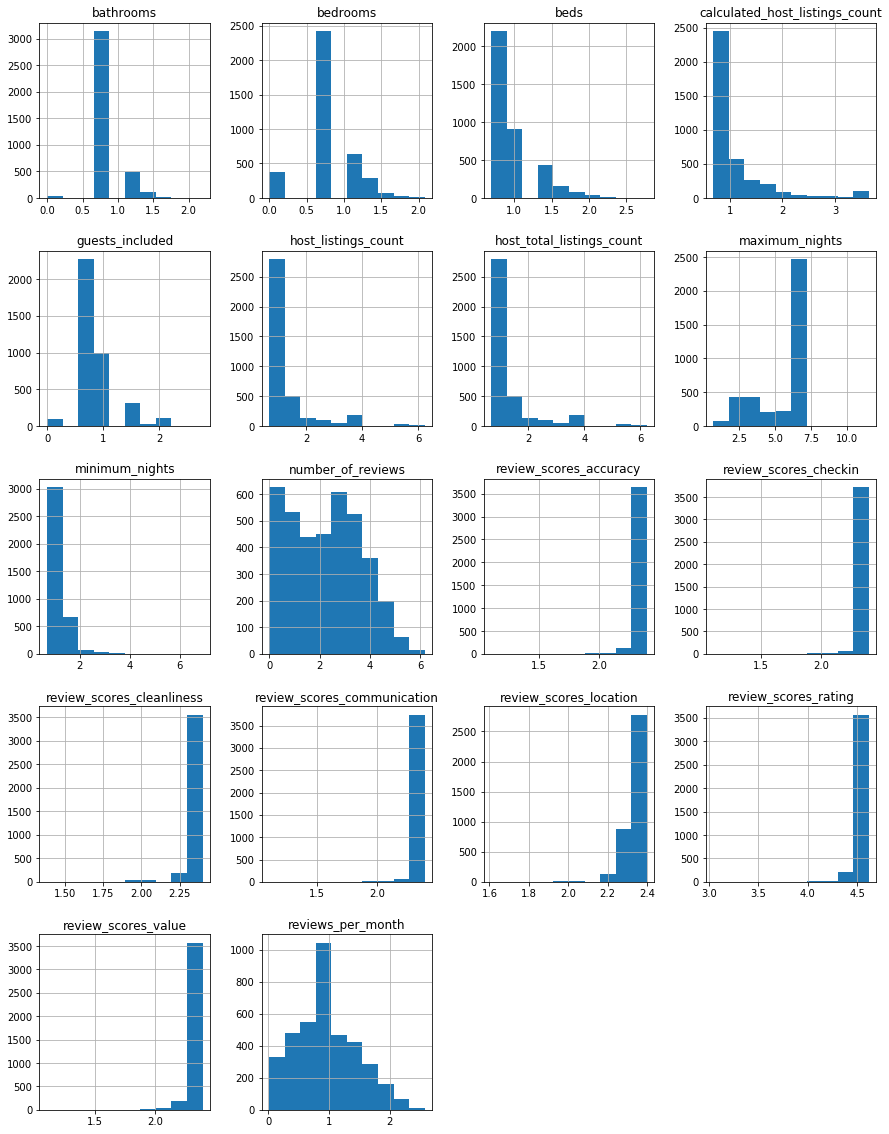

In [90]:
# Log-transform the skewed features
skewed = ['bathrooms', 'bedrooms', 'beds', 'calculated_host_listings_count', 'guests_included', 'host_listings_count', 'host_total_listings_count', 'maximum_nights', 'minimum_nights', 'number_of_reviews', 'review_scores_accuracy', 'review_scores_checkin', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_location', 'review_scores_rating', 'review_scores_value', 'reviews_per_month']
df_clean[skewed] = df_clean[skewed].apply(lambda x: np.log(x + 1))
# Plot the log transformed skewed features
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_clean[skewed].hist(ax = ax)

So some of these distributions have certainly become less skewed by the transformation.

## Question 1: What factors help predict price?

We will aim to predict the 'price' feature based on other features.

There are other price fields (weekly_price & monthly_price) which will most likely be strongly correlated with the 'price' field, but do not really help us predict price from other features. We will drop these.

In [91]:
df_price = df_clean.drop(['weekly_price', 'monthly_price'], axis=1)

Given we know that price is a continous numeric variable, we will try using a linear model to predict price.

We have a large number of features (190 columns), using all of them together may not help us find the best features to predict price. Also, using them all together may cause the model to overfit.

To try to mitigate these issues, we will create a function that will fit the model many times with different rows & different sub-sets of features - and then evaluate the best of these models (using the r2 score) to find the most optimal model that predicts the best.

In [92]:
# Define function to find most optimal linear model
# NOTE: This function not written by me but included from Udacity class material
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=20, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

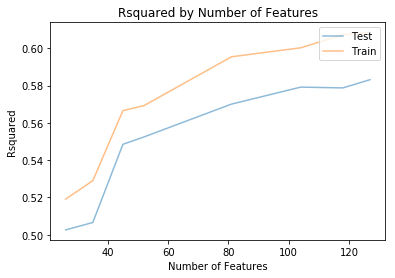

In [93]:
#cutoffs here pertains to the number of missing values allowed in the used columns.
#Therefore, lower values for the cutoff provides more predictors in the model.
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]
#Split into explanatory and response variables
X = df_price.drop(['price'], axis=1)
y = df_price['price']

r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

In [94]:
print(X_train.shape[1]) # Most optimal number of columns/features
print(r2_scores_test[np.argmax(r2_scores_test)]) # The model we should implement test_r2
print(r2_scores_train[np.argmax(r2_scores_test)]) # The model we should implement train_r2

127
0.5831885202953921
0.6086433183889912


To understand which features have the biggest impact on price, we can look at the coefficients of the model.

Below we will write a function that will extract the coefficients weights for a given linear model and then use it to find the biggest weights, which will be the features that have the biggest impact on price.

In [95]:
# Define function to return coefficient weights of linear model
# NOTE: This function not written by me but included from Udacity class material
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(15)

,est_int,coefs,abs_coefs
82,neighbourhood_cleansed_University District,-1581577847344433.000,1581577847344433.000
101,neighbourhood_group_cleansed_University District,1581577847344418.500,1581577847344418.500
121,cancellation_policy_moderate,-1362560444375335.500,1362560444375335.500
120,cancellation_policy_flexible,-1362560444375333.500,1362560444375333.500
122,cancellation_policy_strict,-1362560444375333.250,1362560444375333.250
36,host_response_time_within a day,-459745812303658.625,459745812303658.625
38,host_response_time_within an hour,-459745812303652.562,459745812303652.562
37,host_response_time_within a few hours,-459745812303648.500,459745812303648.500
35,host_response_time_a few days or more,-459745812303646.875,459745812303646.875
40,host_is_superhost_f,-239442692501769.094,239442692501769.094


So we find the following:

Biggest features related postively to price:
- neighbourhood_group_cleansed: 'University District' has a positive impact on price
- room_types: Entire home/apt, Private room, Shared room

Biggest features related negatively to price:
- neighbourhood_cleansed: 'University District' has a negative impact on price
- Several cancellation polices have a negative impact on price (moderate, flexible, strict)
- Various host response times have a negative impact on price

## Question 2: Are superhosts more expensive than non-superhosts?

In answering the previous question where we used a machine learning model to predict price, we saw confusing indications regarding several features - for example the feature 'superhost' (which is either true or false). For the model, it seems this feature being true **and** false both have a negative impact on price. What does this mean?

In this second question we will examine this more closely but from a different angle & with different techniques by asking a different question - does being a superhost effect price? we will use descriptive & inferential statistics to try to answer this question.

Let us first check our two features of interest for data completeness from the original uncleaned dataset.

In [96]:
# Extract features of interest
df_superhost_price = df[['host_is_superhost', 'price']]
# Get info on data completeness
df_superhost_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 2 columns):
host_is_superhost    3816 non-null object
price                3818 non-null object
dtypes: object(2)
memory usage: 59.7+ KB


Ok the dataset is pretty complete bar some missing superhost values, lets drop these rows.

In [97]:
# Drop rows with missing values
df_superhost_price = df_superhost_price.dropna()
# Get info on data completeness
df_superhost_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3816 entries, 0 to 3817
Data columns (total 2 columns):
host_is_superhost    3816 non-null object
price                3816 non-null object
dtypes: object(2)
memory usage: 89.4+ KB


Lets look at a few values to remind ourselves of typical values.

In [98]:
df_superhost_price.head()

,host_is_superhost,price
0,f,$85.00
1,t,$150.00
2,f,$975.00
3,f,$100.00
4,f,$450.00


Lets also clean up the price field, its a formatted string and it should really be a float.

In [99]:
# Remove $
df_superhost_price['price'] = df_superhost_price['price'].str.replace('$','')
# Remove , from thousands i.e. 1,000
df_superhost_price['price'] = df_superhost_price['price'].str.replace(',','')
# Convert to float
df_superhost_price['price'] = df_superhost_price['price'].astype('float')
# Check key stats
df_superhost_price['price'].describe()

count   3816.000
mean     127.952
std       90.251
min       20.000
25%       75.000
50%      100.000
75%      150.000
max     1000.000
Name: price, dtype: float64

Ok so we have quite a wide range of price values for the whole dataset, with the bulk of the distribution (IQR) between 75-150. Lets plot this distribution with a boxplot and histogram to gain further insight.

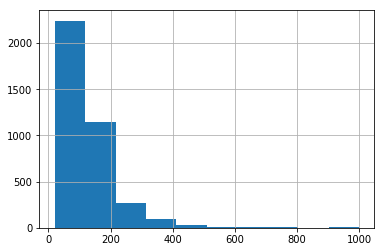

In [100]:
df_superhost_price['price'].hist()

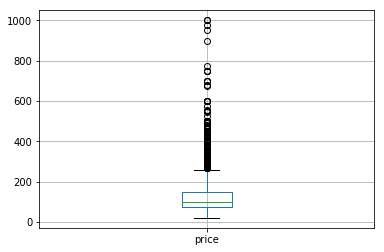

In [101]:
df_superhost_price.boxplot(column=['price'])

We can see from the histogram that the distribution is right skewed, with the bulk of prices being between 0-200 appox.

The boxplot shows us that despite this, there are many outliers above 200, going all the way up to 1000.

Let's now subset the data by superhost type and compare the distributions.

Text(0,0.5,'Number of listings')

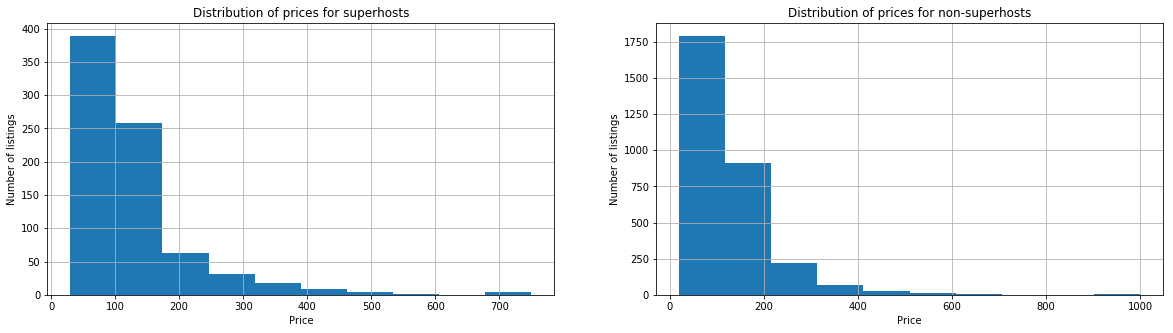

In [102]:
# Get superhost subset
df_superhost = df_superhost_price[df_superhost_price['host_is_superhost'].str.contains("t")]
df_superhost = df_superhost[['price']]
# Get not superhost subset
df_notsuperhost = df_superhost_price[df_superhost_price['host_is_superhost'].str.contains("f")]
df_notsuperhost = df_notsuperhost[['price']]
# Plot histograms for each
fig, axes = plt.subplots(1, 2)
df_superhost['price'].hist(ax=axes[0],figsize=(20,5))
df_notsuperhost['price'].hist(ax=axes[1],figsize=(20,5))
axes[0].set_title('Distribution of prices for superhosts')
axes[0].set_xlabel("Price")
axes[0].set_ylabel("Number of listings")
axes[1].set_title('Distribution of prices for non-superhosts')
axes[1].set_xlabel("Price")
axes[1].set_ylabel("Number of listings")

We can see from the histograms that superhosts seem to more of there values less that 175, whereas non-superhsosts have more of their values less than 200.

We also notice that both distributions are right-skewed.

Also we can see non-superhosts have more extreme values, with highest value of 1000, where superhosts most extreme value is 700.

Lets compare with boxplots.

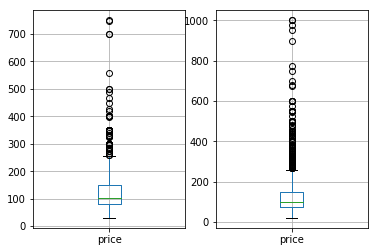

In [103]:
# Plot comparison boxplots
fig, axes = plt.subplots(1, 2)
df_superhost.boxplot(ax=axes[0], column=['price'])
df_notsuperhost.boxplot(ax=axes[1], column=['price'])

This confirms and further illustrates the differences. We can see the bulk of the values for nonsuperhosts (IQR) is more narrow, whereas superhosts IQR is wider.

Lets look at other key stats.

In [104]:
print(df_superhost.describe())
print(df_notsuperhost.describe())
print('')
print('Observed difference in mean price between superhosts and non-superhosts for sample data:')
observed_diff_means = df_superhost['price'].mean() - df_notsuperhost['price'].mean()
print(observed_diff_means)

        price
count 778.000
mean  130.140
std    87.528
min    30.000
25%    79.250
50%   103.000
75%   150.000
max   750.000
         price
count 3038.000
mean   127.391
std     90.941
min     20.000
25%     74.000
50%    100.000
75%    150.000
max   1000.000

Observed difference in mean price between superhosts and non-superhosts for sample data:
2.748726922562696


So looking at the means, it seems like superhosts are slightly more expensive than non-superhosts (by $2.74). 

This is a small difference! But is it a significant difference?

But how can we be more sure that generally for all adverts that superhosts are truely more expensive than non-superhosts?

To answer this, we will use hypothesis testing and confidence intervals.

Lets set up our null and alternate hypotheses for the test.

So will assume that non-superhosts are the same price or more expensive unless the superhosts proves to be definitely more expensive at a Type I error rate of 5%. 

So given $\mu_{s}$ is the mean price of superhosts, and $\mu_{n}$ is the mean price of non-superhosts, we will assume the following hypotheses:

$$H_0: \mu_{n} - \mu_{s} >= 0$$

$$H_1: \mu_{n} - \mu_{s} < 0$$

Therefore we will assume under the null hypothesis, $\mu_{s}$ and $\mu_{n}$ both have equal mean prices, as that is the nearest edge case where the null hypothesis can be true.

We will use a sample size for each mean price in equal proportion to that in the original dataset.

Then we will create a sampling distribution to simulate the difference in mean price between the superhosts and non-superhosts over 10,000 iterations of calculating an estimate from the null using bootstrapping. I will use bootstrap sampling to create the sampling distribution as unlike pre-defined function statistical tests, it has no assumptions regarding the shape of the distribution (i.e. normality).

10,000 iterations of bootstrap sampling should be sufficient for to enable it to better estimate the actual difference in mean price between superhosts and non-superhosts i.e. to estimate our parameter (diff in means) from our confidence interval. 

After simulating observations that would possible be at the top edge of the null, we will then compare this to the actual observed difference, and calculate a p-value to determine how likely our observation came from the null hypothesis. In other words, our p-value will help us determine if there is a statisically significant difference in the mean price between the two groups i.e. if the super hosts really cost more than normal hosts.

Ok lets recap on the edge case value of the null i.e. the mean price superhosts and non-superhosts.

In [105]:
df_superhost_price['price'].mean()

127.95178197064989

Lets define n_superhosts as the number of observations that should be simulated for the superhosts:

In [106]:
n_superhosts = df_superhost.shape[0]
n_superhosts

778

Lets define n_nonsuperhosts as the number of observations that should be simulated for the non-superhosts:

In [107]:
n_nonsuperhosts = df_notsuperhost.shape[0]
n_nonsuperhosts

3038

We will now create a sampling distribution for our statistic (the difference in mean price between superhosts and non-superhosts) under the null hypothesis edge case (that there is no difference in the means) i.e. that the means come from the same distribution - and are essentially equal.

To do this, we will create our sample values by sampling n_superhosts prices from all prices, and n_nonsuperhosts prices from all prices - and take the difference in means 10,000 times - creating our sampling distribution. 

In [108]:
diff_means = []
# For 10,000 iterations
for x in range(10000):
    # Sample n_superhost prices from all data (null edge case hypothesis) 
    superhost_samples = df_superhost_price.sample(n=n_superhosts, replace=True)
    # Sample n_nonsuperhosts prices from all data (null edge case hypothesis)
    nonsuperhost_samples = df_superhost_price.sample(n=n_nonsuperhosts, replace=True)
    # Calculate difference in mean prices
    mean_diff = superhost_samples['price'].mean() - nonsuperhost_samples['price'].mean()
    # ... & save
    diff_means = np.append(diff_means, mean_diff)

We can now plot this distribution, plot our actual observed difference, and calculate a p value - i.e. calculate the probability that our observed difference came from the distribution where there is no difference in the difference in means of superhosts compared to nonsuperhosts.

P value:
0.2145


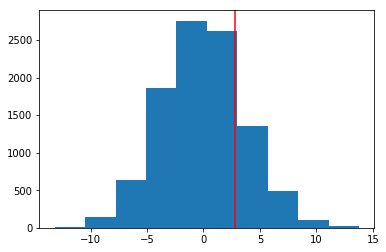

In [109]:
# Plot sampling distribution of mean differences under null edge case hypothesis
plt.hist(diff_means)
# Plot actual observed difference in mean price (in red)
plt.axvline(x=observed_diff_means, color = 'red');
# Calculate p value (one sided test implied by hypotheses)
p_value = (diff_means > observed_diff_means).mean()
print('P value:')
print(p_value)

We stated earlier that in deciding between the hypotheses, we would use a Type 1 error rate of 5% or 0.05 i.e. for a confidence interval of 95%.

Thus, given our p value is bigger than 0.05, we have failed to reject the null hypothesis.

But what does this mean in plain terms, and in relation to our question 'Are superhosts more expensive than non-superhosts'? 

What this result means, is that despite our intial observed small difference in price between superhosts and non-superhosts - we have evidence to suggest that this difference is not significant i.e. that superhosts are not more expensive than superhosts overall.

## Question 3: What factors help us predict a 'superhost' ?

Finally in our last question we will examine if there are any features that help us predict a 'superhost'.

Given the variable we want to predict has two states (superhost is either true or false), logistic regression would be a relevant regression technique we can use in this case.

We will now select features to use for machine learning.

In [110]:
# Copy cleaned dataframe (just original numerical columns plus superhost)
df_superhost = df_clean[['host_is_superhost_t', 'accommodates', 'guests_included', 'minimum_nights', 'maximum_nights',
                        'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews',
                        'calculated_host_listings_count', 'host_listings_count', 'latitude',
                        'longitude', 'bathrooms', 'bedrooms', 'beds', 'review_scores_rating', 'review_scores_accuracy',
                        'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
                        'review_scores_location', 'review_scores_value', 'reviews_per_month']].copy(deep=True)
# We need to add an intercept column for the logsitic regression model base case
df_superhost['intercept'] = 1

Now our data is prepared, lets separate our explanatory & predictor variables, then instantiate & fit our model.

In [111]:
# Split datafame for explanatory and predictive features
X = df_superhost.drop(['host_is_superhost_t'], axis=1)
y = df_superhost['host_is_superhost_t']
# Instantiate & fit our model.
logistic_model = sm.Logit(y, X)
results = logistic_model.fit()

Optimization terminated successfully.
         Current function value: inf
         Iterations 11


Lets now extract the top 10 correlated features that help predict a superhost.

In [112]:
# Calculate exponent of correlation coeeficients for explanatory features
npar = np.exp(results.params)
df_co = pd.DataFrame(data=npar)
df_co = df_co.rename(index=str, columns={0: 'Correlation Coefficient'})
df_co['Correlation Coefficient'] = df_co['Correlation Coefficient'].astype('float')
# Get top 10 correlated features
df_co = df_co.sort_values('Correlation Coefficient', ascending=False)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_co.head(10)

,Correlation Coefficient
review_scores_rating,171872797925.825
review_scores_communication,481.741
review_scores_cleanliness,194.189
review_scores_accuracy,37.168
review_scores_value,17.692
review_scores_checkin,5.460
number_of_reviews,2.717
latitude,2.384
host_listings_count,1.590
guests_included,1.534


It seems like all of the review score features help us predict if someone is a superhost or not. In particular review_scores_rating seems strongly correlated with helping predict a superhost. However, this review score is most likely a composite score calculated from all other review scores.

So the more interesting review score is the next highest component review scores, the most important 2 being review_scores_communication & review_scores_cleanliness. 

In plain terms, good review scores for communication and cleanliness seem to be key features that can help predict a superhost.

## Conclusion

So from this study we got the following answers to the questions posed:

**1. What factors help predict price?**

Biggest features related postively to price:
- neighbourhood_group_cleansed: 'University District' has a positive impact on price
- room_types: Entire home/apt, Private room, Shared room

Biggest features related negatively to price:
- neighbourhood_cleansed: 'University District' has a negative impact on price
- Several cancellation polices have a negative impact on price (moderate, flexible, strict)
- Various host response times have a negative impact on price

**2. Are superhosts more expensive than non-superhosts?**

Despite an observed small difference in price between superhosts and non-superhosts from the data - we have evidence to suggest that this difference is not significant i.e. that superhosts are not more expensive than superhosts overall.

**3. What factors help us predict a 'superhost' ?**

Good review scores for communication and cleanliness are key features that can help predict a superhost.

While it should be emphasised that these findings relate specifically to Airbnb lisitings in Seattle, this findings may also be suggestive of answers to these questions that may also be true for listings anywhere in the world. Further study and analysis of listings data from around the world would be needed to confirm this.